In [1]:
import datetime as dateime
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
import yfinance as yf
import seaborn as sns
import math
yf.pdr_override()
sns.set_style("darkgrid")

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# risk-free rate (10years US Treasury Bond)
r = pdr.get_data_yahoo("^TNX", dateime.datetime.now()-BDay(5), dateime.datetime.now())["Low"].iloc[-1]/100
print("10 year US Treasury Bond: {:.2f}%".format(r*100))

[*********************100%***********************]  1 of 1 completed
10 year US Treasury Bond: 4.21%


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,log_return,volatility_5b,volatility_10b,volatility_20b
Date,,,,,,,,,,
2023-09-01,257.26,259.08,242.01,245.01,245.01,132272500,-0.05,0.71,0.63,0.52
2023-09-05,245.00,258.00,244.86,256.49,256.49,129469600,0.05,0.76,0.57,0.54
2023-09-06,255.14,255.39,245.06,251.92,251.92,116959800,-0.02,0.56,0.59,0.55
2023-09-07,245.07,252.81,243.27,251.49,251.49,115312900,-0.00,0.56,0.59,0.53
2023-09-08,251.22,256.52,246.67,248.50,248.50,118367700,-0.01,0.56,0.57,0.53


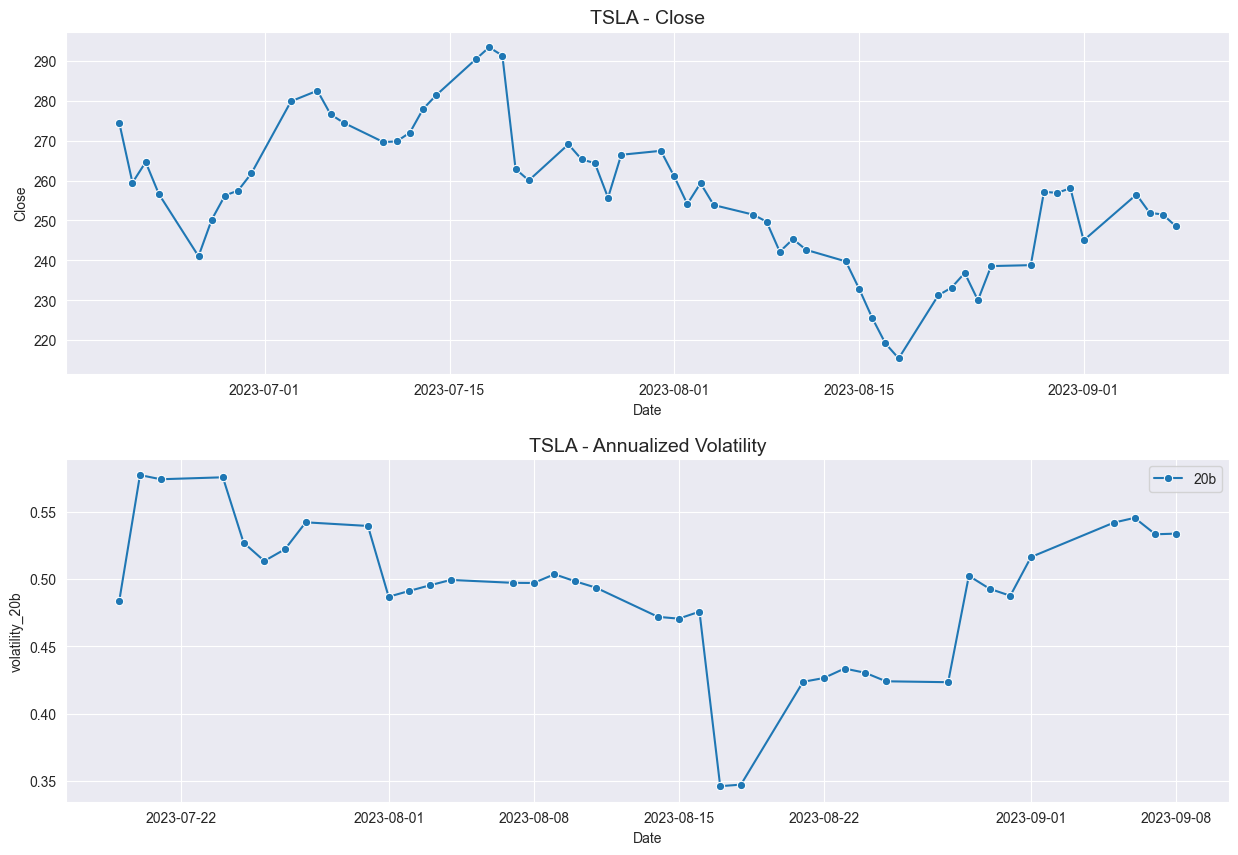

In [3]:
end = dateime.datetime.now()
start = end - BDay(60)

symbol = "TSLA"

df = pdr.get_data_yahoo(symbol, start, end)
df = df.reset_index()
df["Date"] = df["Date"].apply(lambda x: x.date())
df = df.set_index("Date")

df["log_return"] = np.log(df.Close/df.Close.shift(1))
df["volatility_5b"] = df["log_return"].rolling(window=5).std()*np.sqrt(252)
df["volatility_10b"] = df["log_return"].rolling(window=10).std()*np.sqrt(252)
df["volatility_20b"] = df["log_return"].rolling(window=20).std()*np.sqrt(252)

fig, axs = plt.subplots(2,1,figsize=(15,10))
fig.subplots_adjust(hspace=0.25)

ax = axs[0]
sns.lineplot(data=df, x="Date", y="Close", ax=ax, marker="o")
ax.set_title("{} - Close".format(symbol), fontsize=14)

ax = axs[1]
#sns.lineplot(data=df, x="Date", y="volatility_5b", ax=ax, marker="o", label="5b")
#sns.lineplot(data=df, x="Date", y="volatility_10b", ax=ax, marker="o", label="10b")
sns.lineplot(data=df, x="Date", y="volatility_20b", ax=ax, marker="o", label="20b")

ax.legend()
ax.set_title("{} - Annualized Volatility".format(symbol), fontsize=14)
                       
display(df.tail())                       

# Implied Volatility from scratch

In [4]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega, delta

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [5]:
def implied_vol_from_scratch(S0, K, T, r, market_price, flag='c', tol=0.00001, vol_init=0.5):
    """Calculating the implied volatility of an European option
        S0: stock price
        K: strike price
        T: time to maturity
        r: risk-free rate
        market_price: option price in market
    """
    
    max_iter = 200 #max no. of iterations
    vol_old = vol_init #initial guess 
    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime = vega(flag, S0, K, T, r, vol_old)*100
        C = bs_price - market_price
        vol_new = vol_old - C/Cprime
        new_bs_price = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old-vol_new) < tol or abs(new_bs_price-market_price) < tol):
            break
            
        vol_old = vol_new            
    return vol_old

In [6]:
# options input
S0 = 193.49                # current stock price
K = 200                    # strike price
DTE = 60.                  # Days to Expiry
market_price = 2.25        # option price

In [7]:
T = DTE/252
flag = 'c'
tol = 0.00001
vol_hist = df["volatility_20b"].iloc[-1]

iv_calc = implied_vol_from_scratch(S0,K,T,r,market_price, vol_init=vol_hist)
iv_func = implied_volatility(market_price, S0, K, T, r, flag)


print("Current Price:    ${}".format(S0))
print("Strike Price:     ${}".format(K))
print("Option Mkt Price: ${}".format(market_price))
print("Days To Expiry:   {}".format(DTE))
print("Risk-Free Rate:   {}%".format(r*100))
print("=========================================")
print("IV from scratch: {:.3f}%".format(iv_calc*100))
print("IV from library: {:.3f}%".format(iv_func*100))

Current Price:    $193.49
Strike Price:     $200
Option Mkt Price: $2.25
Days To Expiry:   60.0
Risk-Free Rate:   4.2129998207092285%
IV from scratch: 10.814%
IV from library: 10.813%


# Simulate Price at expiry

In [8]:
# Number of sims
M = 1000

# Assume sigma is the IV of the options
#sigma = iv_func
sigma = 0.6

# Assume risk-neutral probability
mu = r
#u = np.mean(df["log_return"].tail(20))*252

DTE_ = math.ceil(DTE)
#DTE_ = 20
last_date  = df.index.values[-1]

df_sim = []

t = np.array([t/252 for t in range(1,DTE_+1)])    
d = np.array([(last_date + BDay(t)).date() for t in range(1,DTE_+1)])
dt = 1/252

for m in range(M):            
    gbm_p = np.exp((mu-0.5*sigma**2)*dt + sigma * np.random.normal(0,np.sqrt(dt), size=(len(t))))        
    gbm_p = S0 * gbm_p.cumprod()    
    gbm_p = pd.Series(data=gbm_p, index=d)        
    df_sim.append(gbm_p)    

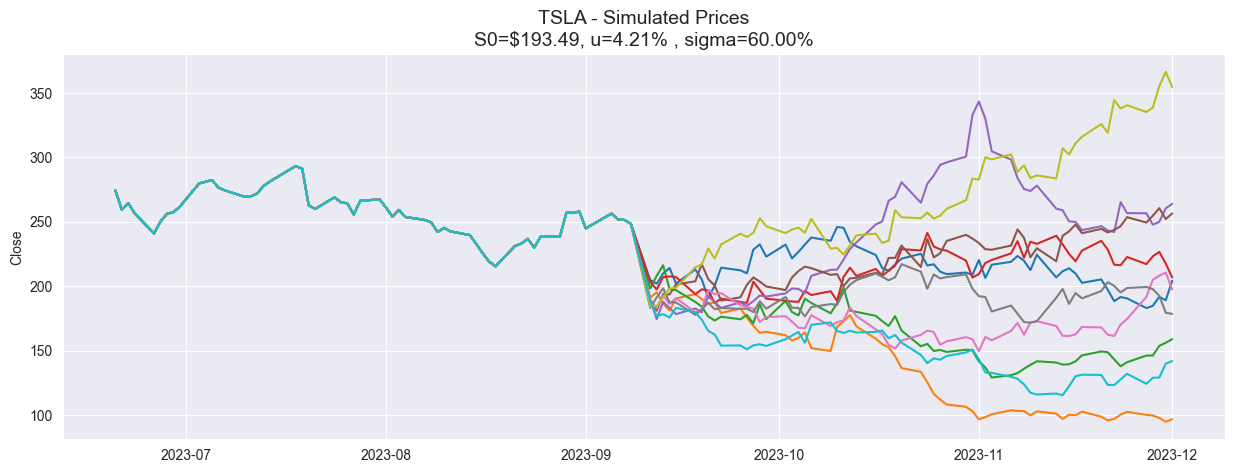

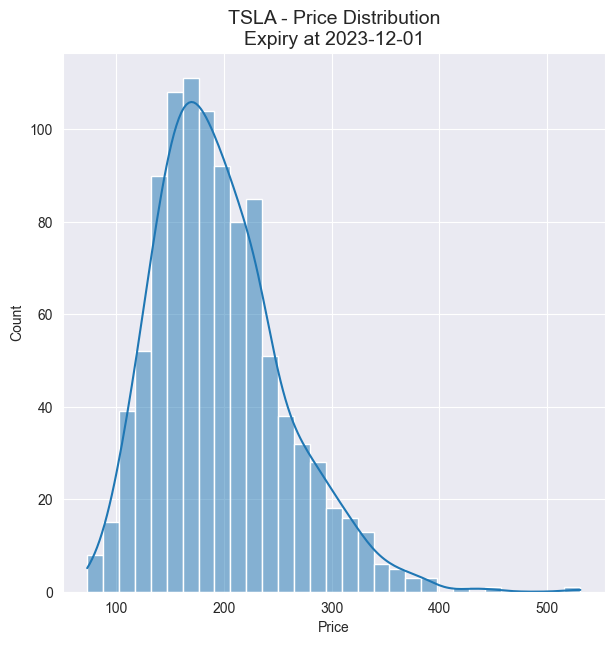

Mean: $196.15
Std:  $59.53


In [9]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
org_prices = df.Close

for i in range(10):
    sim = df_sim[i]
    real_and_sim = pd.concat([org_prices,sim])    
    sns.lineplot(data=real_and_sim,ax=ax)  
    
ax.set_title("{} - Simulated Prices\nS0=${:.2f}, u={:.2f}% , sigma={:.2f}%".format(symbol,S0,mu*100,sigma*100), fontsize=14)
ax.set_ylabel("Close")
plt.show()

fig, ax = plt.subplots(1,1,figsize=(7,7))
closes = [x.values[-1] for x in df_sim]
sns.histplot(x=closes, ax=ax, kde=True)
ax.set_xlabel("Price")
ax.set_title("{} - Price Distribution\nExpiry at {}".format(symbol, d[-1]), fontsize=14)
plt.show()

print("Mean: ${:.2f}".format(np.mean(closes)))
print("Std:  ${:.2f}".format(np.std(closes)))